# 集成学习

## Voting
![](./imgs/1.png)

In [1]:
## 加载相关库
from sklearn.datasets import load_iris   # 加载数据
from sklearn.model_selection import train_test_split  # 切分训练集与测试集
from sklearn.preprocessing import StandardScaler  # 标准化数据
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量

In [2]:
## 初步处理数据
iris = load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)

In [3]:
from sklearn.model_selection import cross_val_score   # 10折交叉验证评价模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline   # 管道简化工作流

In [4]:
# 使用三种不同的分类器
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")

pipe1 = Pipeline([['sc', StandardScaler()], ['clf',clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf',clf3]])

clf_labels = ['Logistic regression','Decision tree','KNN']
print('10-folds cross validation :\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf
                             , X=X_train
                             , y=y_train
                             , cv=10
                             , scoring='roc_auc')
    print("ROC AUC: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))

10-folds cross validation :

ROC AUC: 0.92(+/- 0.15)[Logistic regression]
ROC AUC: 0.87(+/- 0.18)[Decision tree]
ROC AUC: 0.85(+/- 0.13)[KNN]


In [5]:
# 使用MajorityVoteClassifier集成（）hard:类标记　soft:类概率
from sklearn.ensemble import VotingClassifier

mv_clf = VotingClassifier(estimators=[('pipe1', pipe1), ('clf2', clf2), ('pipe3', pipe3)], voting='soft') # 不同类型的预测输出值不能混用
clf_labels += ['MajorityVoteClassifier']
all_clf = [pipe1, clf2, pipe3, mv_clf]
print('10-folds cross validation :\n')

for clf,label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf
                             , X=X_train
                             , y=y_train
                             , cv=10
                             , scoring='roc_auc')
    print("ROC AUC: %0.2f(+/- %0.2f)[%s]"%(scores.mean(), scores.std(), label))
    
## 对比下面结果，可以得知多数投票方式的分类算法，抗差能力更强。

10-folds cross validation :

ROC AUC: 0.92(+/- 0.15)[Logistic regression]
ROC AUC: 0.87(+/- 0.18)[Decision tree]
ROC AUC: 0.85(+/- 0.13)[KNN]
ROC AUC: 0.98(+/- 0.05)[MajorityVoteClassifier]


In [7]:
mv_clf.named_estimators

{'clf2': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'pipe1': Pipeline(memory=None,
          steps=[['sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)],
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='

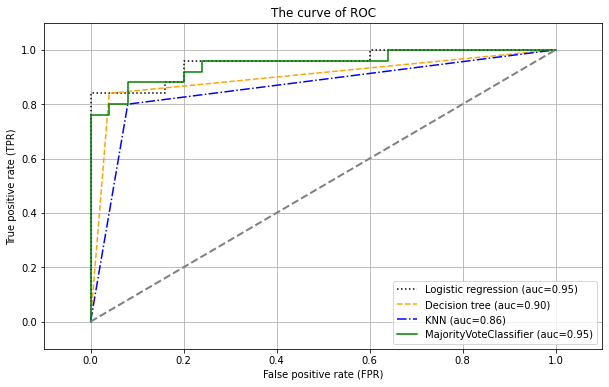

In [8]:
## 使用ROC曲线评估集成分类器
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
plt.figure(figsize=(10, 6))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr, tpr, trhresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)'%(label,roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title("The curve of ROC")
plt.grid()
plt.show()

## Bagging
![](./imgs/2.png)

In [9]:
import pandas as pd
## 我们使用葡萄酒数据集进行建模(数据处理)
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash','Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

df_wine = df_wine[df_wine['Class label'] != 1]  # drop 1 class
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [10]:
from sklearn.model_selection import train_test_split  # 切分训练集与测试集
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [11]:
## 使用单一决策树进行分类：
tree = DecisionTreeClassifier(criterion='entropy'
                              ,random_state=1
                              ,max_depth=None
                             )   #选择决策树为基本分类器

from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [12]:
## 我们使用BaggingClassifier分类：
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy'
                
                              ,random_state=1
                              ,max_depth=None)   #选择决策树为基本分类器

bag = BaggingClassifier(base_estimator=tree
                    , n_estimators=500
                        , max_samples=1.0 # 从X抽取的样本数，用于训练每个基本估计器
                        , max_features=1.0 # 从X中提取的用于训练每个基本估计器的特征数
                        , bootstrap=True
                        , bootstrap_features=False
                        , n_jobs=1
                        , random_state=1
                       )

from sklearn.metrics import accuracy_score
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))


Bagging train/test accuracies 1.000/0.917


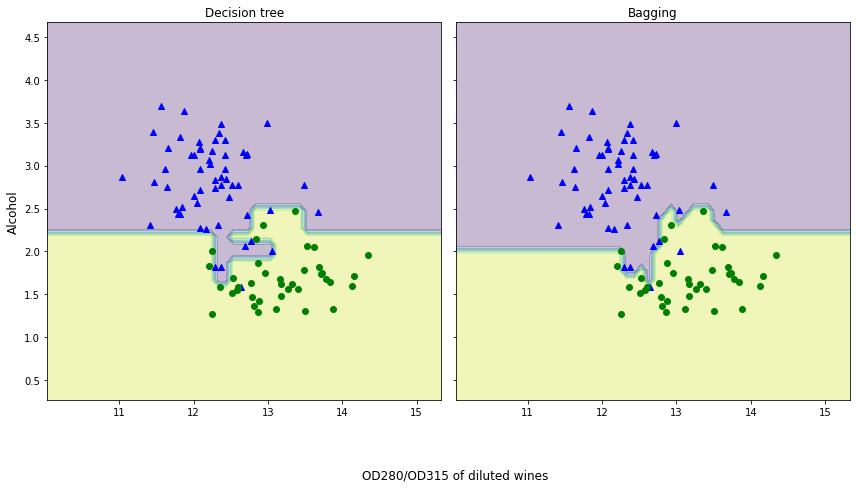

In [13]:
import numpy as np
## 我们来对比下这两个分类方法上的差异
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1
                        , ncols=2
                        , sharex='col'
                        , sharey='row'
                        , figsize=(12, 6)
                       )
for idx, clf, tt in zip([0, 1],[tree, bag],['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

[Bagging 参数解析](https://blog.csdn.net/weixin_46072771/article/details/106319323?utm_medium=distribute.pc_relevant.none-task-blog-title-2&spm=1001.2101.3001.4242)

## boosting

In [14]:
## 我们用单一决策树, 使用决策树桩：
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy'
                              , random_state=1
                              , max_depth=1
                             )

from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [15]:
## 我们使用Adaboost集成建模：
ada = AdaBoostClassifier(base_estimator=tree
                         , n_estimators=500
                         , learning_rate=0.1
                         , random_state=1
                        )

ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


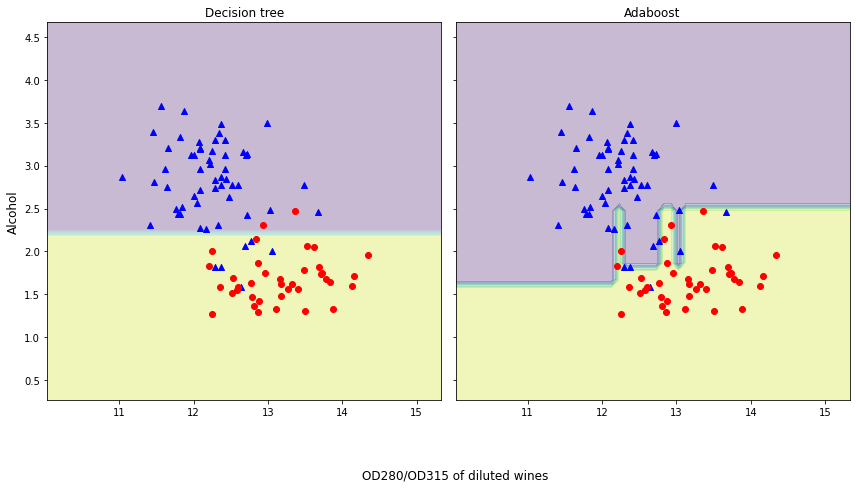

In [16]:
## 我们观察下Adaboost与决策树的异同
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

## Stacking
### 学习策略
![](./imgs/4.jpeg)
### 结果判定
![](./imgs/5.png)

In [17]:
from sklearn import datasets 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

In [45]:
# 创建数据
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

# 创建初级学习器
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()

# 创建次级学习器
lr = LogisticRegression()

### Stacking算法
方法：若此处直接使用初级学习器的训练集来产生次级训练集，则过拟合的风险会比较大，因此，一般是通过使用交差验证或留一法这样的方式,  
用训练初级学习器未使用的样本来产生次级学习的训练样本

In [50]:
from sklearn.model_selection import KFold  # K折交叉验证

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=0)
ntrain = Xtrain.shape[0]
ntest = Xtest.shape[0]
SEED = 0 #for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, shuffle=False)

In [51]:
def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    # 存放K折结果
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr, y_tr)
        
        # 填充所有的测试结果的值
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    # k折平均
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [52]:
# 获得次级学习器的数据
clf1_oof_train, clf1_oof_test = get_out_fold(clf1, Xtrain, Ytrain, Xtest)
clf2_oof_train, clf2_oof_test = get_out_fold(clf2, Xtrain, Ytrain, Xtest)
clf3_oof_train, clf3_oof_test = get_out_fold(clf3, Xtrain, Ytrain, Xtest)

# 拼接数据
model_train = np.concatenate((clf1_oof_train, clf2_oof_train, clf3_oof_train), axis=1)
model_test = np.concatenate((clf1_oof_test, clf2_oof_test, clf3_oof_test), axis=1)

In [53]:
# 评估元学习器
score = cross_val_score(lr, model_train, Ytrain, cv=3, scoring='accuracy')
print("Accuracy: %.2f (+/- %.2f)"%(score.mean(), score.std()))

Accuracy: 0.93 (+/- 0.04)


### mlxtend使用

#### 1.简单使用

In [54]:
# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)
 
print('3-fold cross validation:\n')
 
for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


#### 画出决策边界(基于类标签)

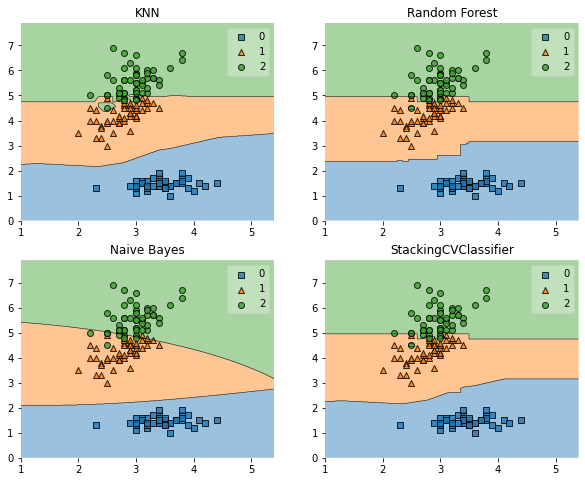

In [55]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf],
                         ['KNN',
                          'Random Forest',
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

#### 2.使用概率作为元特征
说明：有研究表明，将初级学习器的输出类概率作为次级学习器的输入属性，用MLR作为次级学习算法的效果较好。

In [26]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
 
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True, # 设定元学习器为类概率预测
                            meta_classifier=lr,
                            random_state=42)
 
print('3-fold cross validation:\n')
 
for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):
 
    scores = cross_val_score(clf, X, y,
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


#### 画出决策边界(基于类概率)

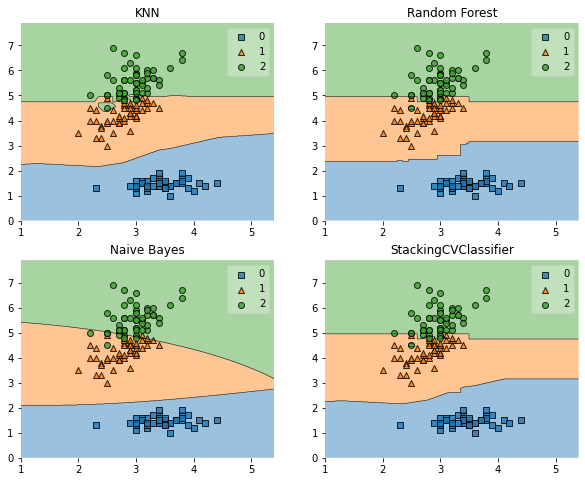

In [58]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf],
                         ['KNN',
                          'Random Forest',
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

#### 3.堆叠5折CV分类与网格搜索(结合网格搜索调参优化)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier
 
# Initializing models
 
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()
 
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=42)
# 参数范围选定 
params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}
 
grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X, y)
 
cv_keys = ('mean_test_score', 'std_test_score', 'params')
 
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))
 
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.947 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [28]:
grid.cv_results_

{'mean_fit_time': array([0.07141986, 0.22590923, 0.07424102, 0.23294392, 0.07587495,
        0.22546563, 0.06739802, 0.24822779]),
 'mean_score_time': array([0.0033361 , 0.00690169, 0.00378203, 0.00638566, 0.00383358,
        0.00670776, 0.00352788, 0.00775528]),
 'mean_test_score': array([0.94666667, 0.93333333, 0.94      , 0.94      , 0.95333333,
        0.95333333, 0.95333333, 0.95333333]),
 'param_kneighborsclassifier__n_neighbors': masked_array(data=[1, 1, 1, 1, 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_meta_classifier__C': masked_array(data=[0.1, 0.1, 10.0, 10.0, 0.1, 0.1, 10.0, 10.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__n_estimators': masked_array(data=[10, 50, 10, 50, 10, 50, 10, 50],
              mask=[False, False, False, False, False, False, Fal

#### 4.在不同特征子集上运行的分类器的堆叠
不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn管道和ColumnSelector：

In [29]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
 
iris = load_iris()
X = iris.data
y = iris.target
 
pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())
 
sclf = StackingCVClassifier(classifiers=[pipe1, pipe2],
                            meta_classifier=LogisticRegression(),
                            random_state=42)
 
sclf.fit(X, y)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2),
                                                                  drop_axis=False)),
                                                  ('logisticregression',
                                                   LogisticRegression(C=1.0,
                                                                      class_weight=None,
                                                                      dual=False,
                                                                      fit_intercept=True,
                                                                      intercept_scaling=1,
                                                                      l1_ratio=None,
                                                                      max_iter=100,
                                        

#### 5.ROC曲线 decision_function
像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。  
请注意，decision_function期望并要求元分类器实现decision_function。

In [60]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [60]:
iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target
 
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
 
RANDOM_SEED = 42
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

In [60]:
 
clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()
 
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)
 
# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

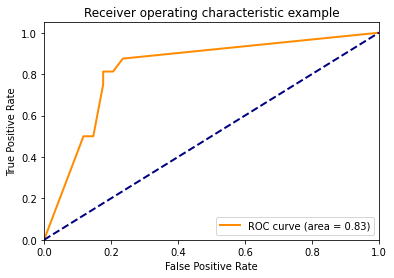

In [61]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 参考
[机器学习集成学习与模型融合！](https://blog.csdn.net/Datawhale/article/details/108030705)